# Non-Negative Matrix Factorization

NMF is a very useful algorithm that finds two non-negative matrices W and H, whose product would approximate the data matrix X. This kind of factorization is used in Topic modeling, "parts-based" learning of image data, dimensionality reduction, etc.

In the most general form, the objective function that we want to minimize is:

$$L = 0.5 * ||X - WH||_{Fro}^2
+ alpha * l1_ratio * ||vec(W)||_1
+ alpha * l1_ratio * ||vec(H)||_1
+ 0.5 * alpha * (1 - l1_ratio) * ||W||_{Fro}^2
+ 0.5 * alpha * (1 - l1_ratio) * ||H||_{Fro}^2$$


In which, we define:

Frobenius norm: $$||A||_{Fro}^2 = \sum_{i,j} A_{ij}^2$$ 

Elementwise L1 norm : $$||vec(A)||_1 = \sum_{i,j} abs(A_{ij})$$ 


**Note 1:** As I discussed in complete details in my project write-up, a different divergence loss can substitute the  $(0.5 * ||X - WH||_{Fro}^2)$ term. This will lead to a different objective function, for example:


$$L = - 0.5 * \sum_i\sum_j[X_{ij}ln(WH)_{ij}- (WH)_{ij}]
+ alpha * l1_ratio * ||vec(W)||_1
+ alpha * l1_ratio * ||vec(H)||_1
+ 0.5 * alpha * (1 - l1_ratio) * ||W||_{Fro}^2
+ 0.5 * alpha * (1 - l1_ratio) * ||H||_{Fro}^2$$


In both of the cases, th L2 prior uses the Frobenious norm and L1 norm uses an elementwise L1 norm. l1-ratio is the factor to control the combination of L1 and L2 norm.

**Here I implement both of these loss functions for the comparison purposes. Note that beta_loss = 2 is euivalent to Frobenious norm penalty and beta_loss = 1 is equalvalent to "kullback-leibler" penalties. Values different from these two would lead to significant slower fits.**

**Note 2:** This objective function can be minimized using the multiplicative update rule and the alternating minimization of W and H that I discussed in the documentation.


# NMF implementation - minimizing Frobenius norm using multiplicative rule:

In [1]:
import random
import numpy as np
from numpy import array
from numpy import transpose
from numpy.matrixlib.defmatrix import matrix

In [2]:
def cost_function(a, b, l1=False):
    """Calculates cost function.
    This function calculates L1-norm (element-wise sum of absolute differences)
    or L2-norm (element-wise sum of square of differences) between the original
    matrix and reconstructed matrix.
    Args:
        a: A NumPy Matrix object representing the original matrix.
        b: A NumPy Matrix object representing the reconstructed matrix.
        l1: A boolean indicating whether or not L1 norm should be used instead
        of L2 norm.
    Returns:
        A double representing the value of cost function.
    """
    cost = 0
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            cost += abs(a[i, j] - b[i, j]) if l1 else pow(a[i, j] - b[i, j], 2)
    return cost


In [3]:
def factorize(data_matrix, num_of_factors=10, num_of_iterations=100, l1=False):
    """Factorizes data matrix and returns weights and factors matrices.
    This function initializes weights and factors matrices with random values
    from uniform distribution and then searches for best solution using
     multiplicative update rules.
    Args:
        data_matrix: A NumPy Matrix object representing the original matrix.
        num_of_factors: An integer representing number of factors to be
        extracted.
        num_of_iterations: Number of iterations for multiplicative update
        rules.
        l1: A boolean indicating whether or not L1-norm should be used instead
        of L2-norm for cost function.
    Returns:
        A tuple consisting out of weights and features matrices.
    """
    if data_matrix[data_matrix < 0]:
        raise ValueError('Matrix contains negative values.')

    w = matrix([[random.random() for i in range(num_of_factors)]
                for j in range(data_matrix.shape[0])])
    h = matrix([[random.random() for i in range(data_matrix.shape[1])]
                for j in range(num_of_factors)])

    for i in range(num_of_iterations):
        cost = cost_function(data_matrix, w * h, l1)
        if cost == 0:
            break
        hn = (transpose(w) * data_matrix)
        hd = (transpose(w) * w * h)
        h = matrix(array(h) * array(hn) / array(hd))
        wn = (data_matrix * transpose(h))
        wd = (w * h * transpose(h))
        w = matrix(array(w) * array(wn) / array(wd))
    return w, h, cost

In [4]:
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])

W, H, cost = factorize(X, num_of_factors=2, num_of_iterations=1000)
print('cost: ', cost)
print(W)
print(H)

cost:  3.00013663017e-29
[[  5.73177920e-01   3.04717627e-05]
 [  5.64078300e-01   2.46367466e-01]
 [  6.71434188e-01   4.43443156e-01]
 [  5.45879060e-01   7.39041455e-01]
 [  4.20323932e-01   1.03463975e+00]
 [  5.27679820e-01   1.23171544e+00]]
[[ 1.74443973  1.74465554]
 [ 4.12391871  0.06444709]]


Equivalent sklearn command:

sklearn.decomposition.NMF(n_components=None, init=random, solver=’mu’, beta_loss=’frobenius’, tol=0.0001, max_iter=200, random_state=0, alpha=0.0, l1_ratio=0.0, verbose=1, shuffle=False)

In [5]:
import numpy as np
from sklearn.decomposition import NMF
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

print('number of iterations:', model.n_iter_)
print('Frobenius norm of the matrix difference, or beta-divergence: ', model.reconstruction_err_)
print('w:   ',W)

print('H:   ',W)

number of iterations: 29
Frobenius norm of the matrix difference, or beta-divergence:  0.0011599349216
w:    [[ 0.          0.46880684]
 [ 0.55699523  0.3894146 ]
 [ 1.00331638  0.41925352]
 [ 1.6733999   0.22926926]
 [ 2.34349311  0.03927954]
 [ 2.78981512  0.06911798]]
H:    [[ 0.          0.46880684]
 [ 0.55699523  0.3894146 ]
 [ 1.00331638  0.41925352]
 [ 1.6733999   0.22926926]
 [ 2.34349311  0.03927954]
 [ 2.78981512  0.06911798]]


NMF is best used with the fit_transform method, which returns the matrix W. The matrix H is stored into the fitted model in the components_ attribute; the method transform will decompose a new matrix X_new based on these stored components:

In [6]:
import numpy as np
X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
from sklearn.decomposition import NMF
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_
X_new = np.array([[1, 0], [1, 6.1], [1, 0], [1, 4], [3.2, 1], [0, 4]])
W_new = model.transform(X_new)

In [7]:
W

array([[ 0.        ,  0.46880684],
       [ 0.55699523,  0.3894146 ],
       [ 1.00331638,  0.41925352],
       [ 1.6733999 ,  0.22926926],
       [ 2.34349311,  0.03927954],
       [ 2.78981512,  0.06911798]])

In [8]:
W_new

array([[ 0.46677737,  0.        ],
       [ 0.        ,  1.66350401],
       [ 0.46677737,  0.        ],
       [ 0.        ,  1.17156989],
       [ 1.2277735 ,  0.29280011],
       [ 0.        ,  0.93701736]])

# Testing NMF implementation:

In [9]:
import nmf

In [10]:
nmf = nmf.NMF()

# create a random sparse matrix
A = nmf.rand_sparse_matrix(100000, 1000, 0.01)
nmf.setup(A, k = 10)
nmf.run(iter_num = 100)

# hard clustering
nmf.clusters()

.
.
.
.
.
.
.
.
.
end


In [11]:
print(nmf.H)

[[  7.72440445e-07   6.26424857e-05   3.08294756e-04 ...,   4.20050334e-04
    1.42933211e-03   2.34844037e-04]
 [  1.11725298e-07   5.23075394e-04   5.06632316e-06 ...,   5.63230219e-05
    6.28557185e-04   2.20530885e-04]
 [  1.26789342e-08   1.40400132e-03   1.19352146e-09 ...,   4.98978586e-04
    5.33493455e-10   6.52876548e-11]
 ..., 
 [  7.42442119e-03   1.12475308e-03   3.88725791e-03 ...,   9.24915431e-08
    5.39759125e-04   2.36365659e-03]
 [  4.57121484e-04   1.49977203e-03   4.00379884e-06 ...,   4.14625902e-07
    3.66791366e-03   9.70729860e-04]
 [  2.47495312e-06   5.16191988e-04   6.81639165e-04 ...,   1.73456522e-07
    2.95069666e-07   1.87302495e-03]]


In [12]:
print(nmf.W.shape)

(100000, 10)


In [13]:
from sklearn.decomposition import NMF

import nmf
nmf = nmf.NMF()

# create a random sparse matrix
A = nmf.rand_sparse_matrix(100000, 1000, 0.01)
nmf.setup(A, k = 10)
# nmf.run(iter_num = 100)

model = NMF(n_components=10, init='random', random_state=0)
W = model.fit_transform(A)
H = model.components_

# hard clustering
nmf.clusters()

In [14]:
print(H)

[[ 0.00324625  0.00344213  0.         ...,  0.          0.          0.        ]
 [ 0.02751249  0.          0.01209483 ...,  0.01725626  0.          0.04048692]
 [ 0.00396359  0.          0.01090291 ...,  0.0050593   0.00754683
   0.00426498]
 ..., 
 [ 0.          0.          0.00945839 ...,  0.00570606  0.00503149
   0.00031676]
 [ 0.00246955  0.07734842  0.01209603 ...,  0.00583202  0.03380933  0.        ]
 [ 0.01174361  0.          0.0056523  ...,  0.01672129  0.08466496
   0.04196977]]


In [15]:
print(W.shape)

(100000, 10)


## test sparse NMF

In [ ]:
from numpy import *
import pandas as pd
import time
import datetime
import numpy as np
import csv
import sparse_nmf as smf
from sklearn.utils.extmath import randomized_svd, squared_norm


file_path = "../sparse_NMF/ml-100k/u1.test"
f = open(file_path)
rows = csv.reader(f)
dic = {}
for row in rows:
    e = row[0].split('\t')
    if not int(e[0]) in dic:
#     if not dic.has_key(int(e[0])):
        dic[int(e[0])] = {}
    dic[int(e[0])][int(e[1])] =int(e[2])
temp = []
for key in dic:
    s = pd.Series(dic[key],name=key)
    temp.append(s)
t = pd.DataFrame(temp)
print (t)
t.to_csv('tna.csv')
t0 = t.fillna(0)
t0.to_csv('t.csv')


file_path = "../sparse_NMF/ml-100k/u1.base"
# file_path = "C:/Users/Wu/Desktop/ml-1m/ratings.dat"

f = open(file_path)
rows = csv.reader(f)

dic = {}
for row in rows:
    e = row[0].split('\t')
    if not int(e[0]) in dic:
#     if not dic.has_key(int(e[0])):
        dic[int(e[0])] = {}
    dic[int(e[0])][int(e[1])] =int(e[2])

temp = []
for key in dic:
    if dic[key].__len__() > 100:
        continue

    s = pd.Series(dic[key],name=key)
    temp.append(s)

# print (s)
b = pd.DataFrame(temp)
print (b)
b.to_csv('bna.csv')
b0 = b.fillna(0)
b0.to_csv('b.csv')



X = np.array(b0)
mf = smf.Sparse_NMF(n_components=50, max_iter=4000, tol=1000, alpha=0.002, beta=0.001, init='random')
W, H = mf.fit(X)
print (mf.n_iter_)
# bob = np.array([5, 5, 0, 0, 0, 5])
# bob.shape = 1,6
# w = mf.transform(bob)

# W, H = sss_mf(RATE_MATRIX)

# nmf = NMF(n_components=10, max_iter=500 )  # 设有2个隐主题
# W = nmf.fit_transform(np.array(f))
# H = nmf.components_

print (W)
print (H)
recon = pd.DataFrame(np.dot(W,H),b0.index,b0.columns)
recon[recon<1] = 1
recon[recon>5] = 5
# recon.to_csv('mf100recon.csv')
print (recon)
d = (t0 - recon) * (t0>0)
# d.to_csv('mf100d.csv')
d.fillna(0,inplace = True)
print (squared_norm(d))

# Nimfa

In [16]:
import nimfa

V = nimfa.examples.medulloblastoma.read(normalize=True)

lsnmf = nimfa.Lsnmf(V, seed='random_vcol', rank=50, max_iter=100)
lsnmf_fit = lsnmf()

print('Rss: %5.4f' % lsnmf_fit.fit.rss())
print('Evar: %5.4f' % lsnmf_fit.fit.evar())
print('K-L divergence: %5.4f' % lsnmf_fit.distance(metric='kl'))
print('Sparseness, W: %5.4f, H: %5.4f' % lsnmf_fit.fit.sparseness())

Rss: 0.0531
Evar: 0.9999
K-L divergence: 20.8496
Sparseness, W: 0.7413, H: 0.8141


In [17]:
import numpy as np

import nimfa

V = np.random.rand(40, 100)
snmf = nimfa.Snmf(V, seed="random_vcol", rank=10, max_iter=12, version='l',
                  eta=1., beta=1e-4, i_conv=10, w_min_change=0)
snmf_fit = snmf()

In [18]:
import numpy as np

import nimfa

V = np.random.rand(40, 100)
snmf = nimfa.Snmf(V, seed="random_c", rank=10, max_iter=12, version='r', eta=1.,
                  beta=1e-4, i_conv=10, w_min_change=0)
snmf_fit = snmf()

In [19]:
import numpy as np
import scipy.sparse as spr

import nimfa

V = spr.csr_matrix([[1, 0, 2, 4], [0, 0, 6, 3], [4, 0, 5, 6]])
print('Target:\n%s' % V.todense())

nmf = nimfa.Nmf(V, max_iter=200, rank=2, update='euclidean', objective='fro')
nmf_fit = nmf()

W = nmf_fit.basis()
print('Basis matrix:\n%s' % W.todense())

H = nmf_fit.coef()
print('Mixture matrix:\n%s' % H.todense())

print('Euclidean distance: %5.3f' % nmf_fit.distance(metric='euclidean'))

sm = nmf_fit.summary()
print('Sparseness Basis: %5.3f  Mixture: %5.3f' % (sm['sparseness'][0], sm['sparseness'][1]))
print('Iterations: %d' % sm['n_iter'])
print('Target estimate:\n%s' % np.dot(W.todense(), H.todense()))

Target:
[[1 0 2 4]
 [0 0 6 3]
 [4 0 5 6]]
Basis matrix:
[[ 8.4997086   0.13531344]
 [ 0.40626263  4.23934875]
 [ 0.          0.        ]]
Mixture matrix:
[[  1.17428373e-01   0.00000000e+00   2.13208537e-01   0.00000000e+00]
 [  2.22044605e-16   0.00000000e+00   1.39478979e+00   0.00000000e+00]]
Euclidean distance: 102.002
Sparseness Basis: 0.947  Mixture: 0.916
Iterations: 200
Target estimate:
[[ 0.99810695  0.          2.00094424  0.        ]
 [ 0.04770676  0.          5.99961901  0.        ]
 [ 0.          0.          0.          0.        ]]


In [20]:
import nimfa.examples

#Run standard nonnegative matrix factorization.
nimfa.examples.synthetic.run_nmf(V);

Factorization method: nmf - update: euclidean obj: fro
Initialization method: random_vcol
Basis matrix W: 
[[  3.39062697   8.9647397    0.89109029   4.27683632   0.67777463
    0.89109029   1.23027175   1.23027175   3.18124523   0.67777463]
 [  4.5003266    1.826356    10.385174     1.53572562   0.          10.385174
    0.           0.           4.87396321   0.        ]
 [  4.73795948   5.05396488   4.16050331   5.89145457   4.58044683
    4.16050331   3.07749039   3.07749039   4.28331951   4.58044683]]
Mixture (Coefficient) matrix H0: 
[[ 0.          0.          0.13659552  0.10225909]
 [ 0.01918685  0.          0.03336763  0.1775303 ]
 [ 0.          0.          0.23381908  0.06358631]
 [ 0.11053803  0.          0.09863864  0.22609411]
 [ 0.34405025  0.          0.08343777  0.18927163]
 [ 0.          0.          0.23381908  0.06358631]
 [ 0.          0.          0.09050288  0.10434214]
 [ 0.          0.          0.09050288  0.10434214]
 [ 0.01031248  0.          0.06448009  0.108684

/Users/anvaribs/anaconda/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:1280: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))


In [22]:
# Run probabilistic matrix factorization.
# nimfa.examples.synthetic.run_pmf(V)

In [23]:
import nimfa.examples
nimfa.examples.recommendations.run()

Read MovieLens data set
Algorithm: snmf - r
Initialization: random_vcol
Rank: 30
Stats:
            - iterations: 30
            - Euclidean distance: 114054.793
            - Sparseness basis: 0.146, mixture: 0.415
RMSE: 1.299
Read MovieLens data set
Algorithm: snmf - r
Initialization: random_vcol
Rank: 30
Stats:
            - iterations: 30
            - Euclidean distance: 113621.414
            - Sparseness basis: 0.141, mixture: 0.471
RMSE: 1.305


# testing Sparse PCA implementation:

It finds the set of sparse components that can reconstruct the data matrix efficiently. Increasing alpha, increase the amount of sparseness of the sparse components.

In [24]:
from sklearn.decomposition import TruncatedSVD, SparsePCA, RandomizedPCA
from scipy import sparse as sp


Create a random sparse matrix with 0.01% of its data as non-zeros.

In [25]:
X = sp.rand(1000, 1000, density=0.0001)

Apply PCA to it:


In [26]:
clf = TruncatedSVD(100)
Xpca = clf.fit_transform(X)

Now, check the results:

In [27]:
type(X)

scipy.sparse.coo.coo_matrix

In [28]:
type(Xpca)

numpy.ndarray

In [29]:
print(np.count_nonzero(Xpca), Xpca.size)

17573 100000


which suggests that 17859 of the entries are non-zero, however,

In [30]:
np.isclose(Xpca, 0, atol=1e-15).sum(), Xpca.size

(99097, 100000)

In [31]:
clf.explained_variance_ratio_.sum()

1.000000000000002

### Beta divergence loss functions

In [32]:
import numpy as np
import numbers
import scipy.sparse as sp


EPSILON = np.finfo(np.float32).eps


def squared_norm(x):
    """Squared Euclidean or Frobenius norm of x.
    Returns the Euclidean norm when x is a vector, the Frobenius norm when x
    is a matrix (2-d array). Faster than norm(x) ** 2.
    """
    x = np.ravel(x, order='K')
    if np.issubdtype(x.dtype, np.integer):
        warnings.warn('Array type is integer, np.dot may overflow. '
                      'Data should be float type to avoid this issue',
                      UserWarning)
    return np.dot(x, x)



def _beta_loss_to_float(beta_loss):
    """Convert string beta_loss to float"""
    allowed_beta_loss = {'frobenius': 2,
                         'kullback-leibler': 1,
                         'itakura-saito': 0}
    if isinstance(beta_loss, str) and beta_loss in allowed_beta_loss:
        beta_loss = allowed_beta_loss[beta_loss]

    if not isinstance(beta_loss, numbers.Number):
        raise ValueError('Invalid beta_loss parameter: got %r instead '
                         'of one of %r, or a float.' %
                         (beta_loss, allowed_beta_loss.keys()))
    return beta_loss




def beta_divergence(X, W, H, beta, square_root=False):
    """Compute the beta-divergence of X and dot(W, H).
    Parameters
    ----------
    X : float or array-like, shape (n_samples, n_features)
    W : float or dense array-like, shape (n_samples, n_components)
    H : float or dense array-like, shape (n_components, n_features)
    beta : float, string in {'frobenius', 'kullback-leibler', 'itakura-saito'}
        Parameter of the beta-divergence.
        If beta == 2, this is half the Frobenius *squared* norm.
        If beta == 1, this is the generalized Kullback-Leibler divergence.
        If beta == 0, this is the Itakura-Saito divergence.
        Else, this is the general beta-divergence.
    square_root : boolean, default False
        If True, return np.sqrt(2 * res)
        For beta == 2, it corresponds to the Frobenius norm.
    Returns
    -------
        res : float
            Beta divergence of X and np.dot(X, H)
    """
    beta = _beta_loss_to_float(beta)

    # The method can be called with scalars
    if not sp.issparse(X):
        X = np.atleast_2d(X)
    W = np.atleast_2d(W)
    H = np.atleast_2d(H)

    # Frobenius norm
    if beta == 2:
        # Avoid the creation of the dense np.dot(W, H) if X is sparse.
        if sp.issparse(X):
            norm_X = np.dot(X.data, X.data)
            norm_WH = trace_dot(np.dot(np.dot(W.T, W), H), H)
            cross_prod = trace_dot((X * H.T), W)
            res = (norm_X + norm_WH - 2. * cross_prod) / 2.
        else:
            res = squared_norm(X - np.dot(W, H)) / 2.

        if square_root:
            return np.sqrt(res * 2)
        else:
            return res

    if sp.issparse(X):
        # compute np.dot(W, H) only where X is nonzero
        WH_data = _special_sparse_dot(W, H, X).data
        X_data = X.data
    else:
        WH = np.dot(W, H)
        WH_data = WH.ravel()
        X_data = X.ravel()

    # do not affect the zeros: here 0 ** (-1) = 0 and not infinity
    WH_data = WH_data[X_data != 0]
    X_data = X_data[X_data != 0]

    # used to avoid division by zero
    WH_data[WH_data == 0] = EPSILON

    # generalized Kullback-Leibler divergence
    if beta == 1:
        # fast and memory efficient computation of np.sum(np.dot(W, H))
        sum_WH = np.dot(np.sum(W, axis=0), np.sum(H, axis=1))
        # computes np.sum(X * log(X / WH)) only where X is nonzero
        div = X_data / WH_data
        res = np.dot(X_data, np.log(div))
        # add full np.sum(np.dot(W, H)) - np.sum(X)
        res += sum_WH - X_data.sum()

    # Itakura-Saito divergence
    elif beta == 0:
        div = X_data / WH_data
        res = np.sum(div) - np.product(X.shape) - np.sum(np.log(div))

    # beta-divergence, beta not in (0, 1, 2)
    else:
        if sp.issparse(X):
            # slow loop, but memory efficient computation of :
            # np.sum(np.dot(W, H) ** beta)
            sum_WH_beta = 0
            for i in range(X.shape[1]):
                sum_WH_beta += np.sum(np.dot(W, H[:, i]) ** beta)

        else:
            sum_WH_beta = np.sum(WH ** beta)

        sum_X_WH = np.dot(X_data, WH_data ** (beta - 1))
        res = (X_data ** beta).sum() - beta * sum_X_WH
        res += sum_WH_beta * (beta - 1)
        res /= beta * (beta - 1)

    if square_root:
        return np.sqrt(2 * res)
    else:
        return res

Automatically created module for IPython interactive environment


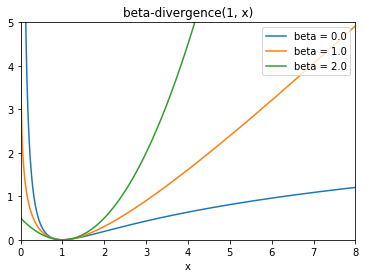

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition.nmf import _beta_divergence

print(__doc__)

x = np.linspace(0.001, 10, 1000)
y = np.zeros(x.shape)

# colors = 'mbgyr'
for j, beta in enumerate((0., 1., 2.)):
    for i, xi in enumerate(x):
        y[i] = beta_divergence(1, xi, 1, beta)
    name = "beta = %1.1f" % beta
    plt.plot(x, y, label=name)

plt.xlabel("x")
plt.title("beta-divergence(1, x)")
plt.legend(loc=1)
plt.axis([0, 8, 0, 5])
plt.show()


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.103s
Extracting the top 6 Non-negative components - NMF...
done in 0.206s
Extracting the top 6 Independent components - FastICA...
done in 0.303s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 0.868s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 0.612s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.072s
Extracting the top 6 Factor Analysis components - FA...
done in 0.088s


/Users/anvaribs/anaconda/lib/python3.5/site-packages/sklearn/decomposition/factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


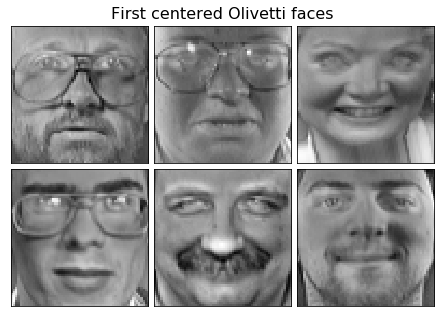

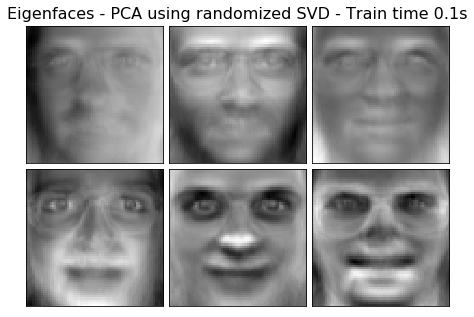

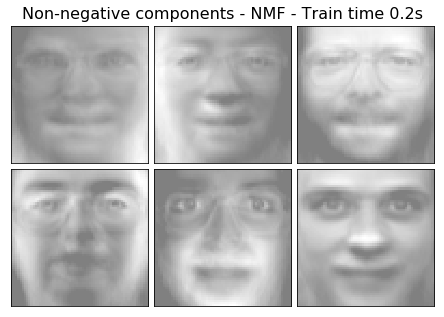

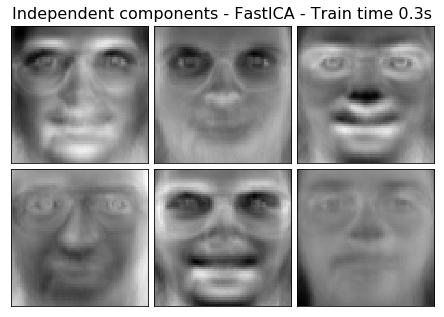

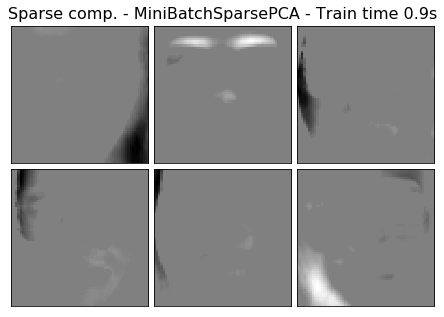

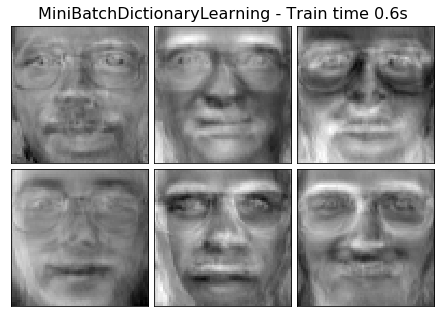

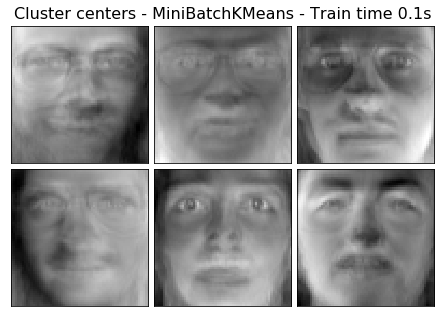

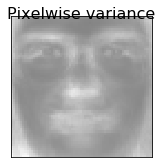

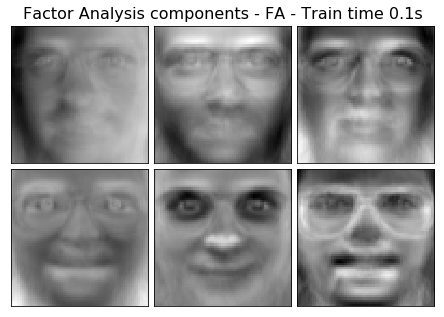

In [34]:
import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

## NMF vs LDA

This is an example of applying NMF and Latent Dirichlet Allocation on a corpus of documents and extract additive models of the topic structure of the corpus. The output is a list of topics, each represented as a list of terms (weights are not shown).


Non-negative Matrix Factorization is applied with two different objective functions: the Frobenius norm, and the generalized Kullback-Leibler divergence. The latter is equivalent to Probabilistic Latent Semantic Indexing.


The default parameters (n_samples / n_features / n_components) should make the example runnable in a couple of tens of seconds. You can try to increase the dimensions of the problem, but be aware that the time complexity is polynomial in NMF. In LDA, the time complexity is proportional to (n_samples * iterations).

In [35]:
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Loading dataset...
done in 1.633s.
Extracting tf-idf features for NMF...
done in 0.444s.
Extracting tf features for LDA...
done in 0.427s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.279s.

Topics in NMF model (Frobenius norm):
Topic #0: just people don think like know time good make way really say right ve want did ll new use years
Topic #1: windows use dos using window program os drivers application help software pc running ms screen files version card code work
Topic #2: god jesus bible faith christian christ christians does heaven sin believe lord life church mary atheism belief human love religion
Topic #3: thanks know does mail advance hi info interested email anybody looking card help like appreciated information send list video need
Topic #4: car cars tires miles 00 new engine insurance price condition oil power speed good 000 brake year models used bought
Topic #5: edu soon com send university internet mit ftp m

In [22]:
import numpy as np
import scipy.sparse as spr

import nimfa

V = spr.csr_matrix([[1, 0, 2, 4], [0, 0, 6, 3], [4, 0, 5, 6]])

nmf = nimfa.Nmf(V, max_iter=200, rank=2, update='euclidean', objective='fro')
nmf_fit = nmf()


print('Euclidean distance: %5.3f' % nmf_fit.distance(metric='euclidean'))

sm = nmf_fit.summary()
print('Sparseness Basis: %5.3f  Mixture: %5.3f' % (sm['sparseness'][0], sm['sparseness'][1]))
print('Iterations: %d' % sm['n_iter'])

Euclidean distance: 65.351
Sparseness Basis: 0.520  Mixture: 0.651
Iterations: 19


In [3]:
import numpy as np

import nimfa

V = np.random.rand(30, 20)

init_W = np.random.rand(30, 4)
init_H = np.random.rand(4, 20)

# Fixed initialization of latent matrices
nmf = nimfa.Nmf(V, seed="fixed", W=init_W, H=init_H, rank=4)
nmf_fit = nmf()

print("Euclidean distance: %5.3f" % nmf_fit.distance(metric="euclidean"))
print('Initialization type: %s' % nmf_fit.seeding)
print('Iterations: %d' % nmf_fit.n_iter)

Euclidean distance: 33.635
Initialization type: fixed
Iterations: 30


# Standard Non-negative Matrix factorization tests for nimfa:

In [18]:
import numpy as np

import nimfa

V = np.random.rand(40, 100)
nmf = nimfa.Nmf(V, seed="nndsvd", rank=10, max_iter=12, update='euclidean',
                objective='fro')
nmf_fit = nmf()

print('Euclidean distance: %5.3f' % nmf_fit.distance(metric='euclidean'))

sm = nmf_fit.summary()
print('Sparseness Basis: %5.3f  Mixture: %5.3f' % (sm['sparseness'][0], sm['sparseness'][1]))
print('Iterations: %d' % sm['n_iter'])

Euclidean distance: 220.035
Sparseness Basis: 0.476  Mixture: 0.553
Iterations: 12


In [19]:
import numpy as np

import nimfa

V = np.random.rand(40, 100)
nmf = nimfa.Nmf(V, seed="random_c", rank=10, max_iter=12, update='divergence',
                objective='div')
nmf_fit = nmf()

print('Euclidean distance: %5.3f' % nmf_fit.distance(metric='euclidean'))

sm = nmf_fit.summary()
print('Sparseness Basis: %5.3f  Mixture: %5.3f' % (sm['sparseness'][0], sm['sparseness'][1]))
print('Iterations: %d' % sm['n_iter'])

Euclidean distance: 293.673
Sparseness Basis: 0.095  Mixture: 0.108
Iterations: 12


In [20]:
import numpy as np

import nimfa

V = np.random.rand(40, 100)
nmf = nimfa.Nmf(V, rank=10, seed="random_vcol", max_iter=200, update='euclidean',
                objective='conn', conn_change=40)
nmf_fit = nmf()

print('Euclidean distance: %5.3f' % nmf_fit.distance(metric='euclidean'))

sm = nmf_fit.summary()
print('Sparseness Basis: %5.3f  Mixture: %5.3f' % (sm['sparseness'][0], sm['sparseness'][1]))
print('Iterations: %d' % sm['n_iter'])

Euclidean distance: 192.671
Sparseness Basis: 0.401  Mixture: 0.359
Iterations: 200
